In [2]:
import pandas as pd
import numpy as np
import itertools 
from sklearn.model_selection import train_test_split
from sklearn import linear_model, svm
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix,accuracy_score, recall_score
import matplotlib.pyplot as plt
import datetime
from sklearn.kernel_approximation import RBFSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
import xgboost as xgb
from sklearn.metrics import f1_score
from xgboost import plot_tree
from xgboost import plot_importance
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

In [3]:
file = 'C:\\Users\\RAUL\\Documents\\OrgDatos2\\Data\\events_TP2.csv'
testFile = 'C:\\Users\\RAUL\\Documents\\OrgDatos2\\Data\\events_TEST.csv'
trainingFile = 'C:\\Users\\RAUL\\Documents\\OrgDatos2\\Data\\events_TRAINING.csv'

In [6]:
df = pd.read_csv(file)
test = pd.read_csv(testFile)
training = pd.read_csv(trainingFile)

C:\Users\RAUL\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df['person'].nunique()

38829

In [7]:
test['person'].nunique()

19415

In [8]:
training['person'].nunique()

19414

In [17]:
control = test.merge(training, how = 'right', on = 'person', indicator = True)

In [18]:
control['_merge'].value_counts()

right_only    19414
both              0
left_only         0
Name: _merge, dtype: int64

In [11]:
training['person'].head()

0    0566e9c1
1    6ec7ee77
2    abe7a2fb
3    34728364
4    87ed62de
Name: person, dtype: object

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [5]:
df.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
0,2018-05-18 00:11:59,viewed product,4886f805,NaN,9288.0,Samsung Galaxy J7 Prime,Excelente,32GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-05-18 00:11:27,viewed product,ad93850f,NaN,304.0,iPhone 5s,Muito Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-05-18 00:11:16,viewed product,0297fc1e,NaN,6888.0,iPhone 6S,Muito Bom,64GB,Prateado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-05-18 00:11:14,viewed product,2d681dd8,NaN,11890.0,iPhone 7,Bom,128GB,Vermelho,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-05-18 00:11:09,viewed product,cccea85e,NaN,7517.0,LG G4 H818P,Excelente,32GB,Branco,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.sort_values(['person', 'timestamp'] , inplace = True)

In [7]:
#df['timestamp2'] = df[df['event'] == 'visited site']['timestamp'] - datetime.timedelta(seconds=3)
#df.timestamp2 = np.where(df.timestamp2.notnull(),
#                      df.timestamp2,
#                      df.timestamp)

In [8]:
#df['inicio visita'] = df['event'].agg(lambda x : True if x == 'visited site' else False)

In [12]:
personas = df[['person']].drop_duplicates()

In [14]:
def sesiones_feature(df, personas, tiempo_inactividad):
    gt_30min = df.timestamp.diff() > datetime.timedelta(minutes=30)
    diff_user = df.person != df.person.shift()
    df['# Visita'] = (diff_user | gt_30min).cumsum()
    duracion_sesiones = pd.DataFrame(df.groupby(['person', '# Visita'])['timestamp'].agg(lambda x : x.max() - x.min())).reset_index()
    sumas_sesiones = pd.DataFrame(duracion_sesiones.groupby('person')['timestamp'].sum()).reset_index().rename(columns = {'timestamp' : 'sum'})
    cantidad_sesiones =  pd.DataFrame(duracion_sesiones.groupby('person')['timestamp'].count()).reset_index().rename(columns = {'timestamp' : 'cantidad_sesiones'})
    sesiones = sumas_sesiones.merge(cantidad_sesiones, on = 'person')
    sesiones['promedio_sesiones'] = pd.to_timedelta(pd.to_timedelta(sesiones['sum'])/sesiones['cantidad_sesiones'], unit = 'ns').dt.round('1s')
    sesiones['promedio_sesiones_sec'] = sesiones['promedio_sesiones'].dt.total_seconds()
    return personas.merge(sesiones, on = 'person', how = 'left').fillna(0)

In [19]:
#act30 = df[df['timestamp'] >= pd.to_datetime('2018-04-30')].groupby('person')['timestamp'].count().reset_index().rename(columns = {'timestamp' : '#act_ult30dias'})

In [460]:
def marcas_vistas_feature(df, personas):
    samsung_vistos = df[(df['event'] == 'viewed product') & (df['model'].str.lower().str.contains('samsung') == True)].groupby('person')['timestamp'].count().reset_index().rename(columns = {'timestamp' : 'samsung_vistos'})
    iphone_vistos  = df[(df['event'] == 'viewed product') & (df['model'].str.lower().str.contains('iphone') == True)].groupby('person')['timestamp'].count().reset_index().rename(columns = {'timestamp' : 'iphone_vistos'})
    motorola_vistos = df[(df['event'] == 'viewed product') & (df['model'].str.lower().str.contains('motorola') == True)].groupby('person')['timestamp'].count().reset_index().rename(columns = {'timestamp' : 'motorola_vistos'})
    marcas_vistas = samsung_vistos.merge(iphone_vistos, on = 'person', how = 'left').fillna(0)
    marcas_vistas = marcas_vistas.merge(motorola_vistos, on = 'person', how = 'left').fillna(0)
    return personas.merge(marcas_vistas, on = 'person', how = 'left')

In [ ]:
def modelos_distintos_vistos(df, personas):
    modelos_vistos = df[df['event'] == 'viewed product'].groupby('person')['model'].agg({'modelos_vistos': 'count',
                                                                                      'modelos_distintos': 'nunique'})
    sku_vistos = df[df['event'] == 'viewed product'].groupby('person')['sku'].agg({'sku_distintos': 'nunique'})
    personas.merge(modelos_vistos)

Analizaremos los caminos que realizan las personas antes de comprar

In [462]:
paths = df.sort_values(by = 'timestamp').copy()

In [463]:
paths['#Camino'] = paths.groupby('person')['event'].apply(lambda x : x.eq('conversion').shift().fillna(0).cumsum())

In [464]:
paths['person'].nunique()

38829

C:\Users\RAUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


C:\Users\RAUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [467]:
paths2 = paths.groupby(['person','#Camino'])['event'].apply(list).reset_index().rename(columns = {'event' : 'camino'})

In [468]:
paths2['person'].nunique()

38829

In [469]:
camino = paths.groupby(['person','#Camino'])['event'].apply(list).reset_index().rename(columns = {'event' : 'camino'})['camino']

In [470]:
def compro(x):
    if('conversion' in x):
        return True
    else:
        return False
    
def borrarRepe(lista):
    return [x[0] for x in itertools.groupby(lista)]

def eliminarConv(x):
    if('conversion' in x):
        return x.remove('conversion')
    else:
        return x

In [471]:
paths2['compro'] = paths2['camino'].apply(lambda x : compro(x))

In [472]:
paths2.head()

,person,#Camino,camino,compro
0,0008ed71,0,"[checkout, visited site, checkout, visited sit...",False
1,00091926,0,"[visited site, viewed product, viewed product,...",False
2,00091a7a,0,"[ad campaign hit, visited site, brand listing,...",False
3,000ba417,0,"[visited site, generic listing, viewed product...",True
4,000c79fe,0,"[ad campaign hit, search engine hit, visited s...",False


In [473]:
paths2['person'].nunique()

38829

In [474]:
paths2['camino'].apply(lambda x : eliminarConv(x))

0        [checkout, visited site, checkout, visited sit...
1        [visited site, viewed product, viewed product,...
2        [ad campaign hit, visited site, brand listing,...
3                                                     None
4        [ad campaign hit, search engine hit, visited s...
5        [generic listing, search engine hit, visited s...
6        [generic listing, search engine hit, visited s...
7                                                     None
8                   [checkout, visited site, visited site]
9        [visited site, ad campaign hit, viewed product...
10       [visited site, viewed product, ad campaign hit...
11       [generic listing, ad campaign hit, visited sit...
12                                                    None
13                      [checkout, visited site, checkout]
14                                                    None
15                                                    None
16       [generic listing, viewed product, viewed produ.

In [475]:
paths2.rename(columns = {'camino' : 'camino_sin_compra'}, inplace = True)

In [476]:
paths2.head(20)

,person,#Camino,camino_sin_compra,compro
0,0008ed71,0,"[checkout, visited site, checkout, visited sit...",False
1,00091926,0,"[visited site, viewed product, viewed product,...",False
2,00091a7a,0,"[ad campaign hit, visited site, brand listing,...",False
3,000ba417,0,"[visited site, generic listing, viewed product...",True
4,000c79fe,0,"[ad campaign hit, search engine hit, visited s...",False
5,000e4d9e,0,"[generic listing, search engine hit, visited s...",False
6,000e619d,0,"[generic listing, search engine hit, visited s...",False
7,001001be,0,"[generic listing, visited site, searched produ...",True
8,001001be,1,"[checkout, visited site, visited site]",False
9,0010e89a,0,"[visited site, ad campaign hit, viewed product...",False


In [477]:
paths2['camino_con_compra'] = camino.copy()

In [478]:
paths2

,person,#Camino,camino_sin_compra,compro,camino_con_compra
0,0008ed71,0,"[checkout, visited site, checkout, visited sit...",False,"[checkout, visited site, checkout, visited sit..."
1,00091926,0,"[visited site, viewed product, viewed product,...",False,"[visited site, viewed product, viewed product,..."
2,00091a7a,0,"[ad campaign hit, visited site, brand listing,...",False,"[ad campaign hit, visited site, brand listing,..."
3,000ba417,0,"[visited site, generic listing, viewed product...",True,"[visited site, generic listing, viewed product..."
4,000c79fe,0,"[ad campaign hit, search engine hit, visited s...",False,"[ad campaign hit, search engine hit, visited s..."
5,000e4d9e,0,"[generic listing, search engine hit, visited s...",False,"[generic listing, search engine hit, visited s..."
6,000e619d,0,"[generic listing, search engine hit, visited s...",False,"[generic listing, search engine hit, visited s..."
7,001001be,0,"[generic listing, visited site, searched produ...",True,"[generic listing, visited site, searched produ..."
8,001001be,1,"[checkout, visited site, visited site]",False,"[checkout, visited site, visited site]"
9,0010e89a,0,"[visited site, ad campaign hit, viewed product...",False,"[visited site, ad campaign hit, viewed product..."


In [479]:
paths2['#pasos_antes_comprar'] = paths2['camino_sin_compra'].apply(lambda x : len(x))

In [480]:
paths2

,person,#Camino,camino_sin_compra,compro,camino_con_compra,#pasos_antes_comprar
0,0008ed71,0,"[checkout, visited site, checkout, visited sit...",False,"[checkout, visited site, checkout, visited sit...",6
1,00091926,0,"[visited site, viewed product, viewed product,...",False,"[visited site, viewed product, viewed product,...",448
2,00091a7a,0,"[ad campaign hit, visited site, brand listing,...",False,"[ad campaign hit, visited site, brand listing,...",10
3,000ba417,0,"[visited site, generic listing, viewed product...",True,"[visited site, generic listing, viewed product...",205
4,000c79fe,0,"[ad campaign hit, search engine hit, visited s...",False,"[ad campaign hit, search engine hit, visited s...",17
5,000e4d9e,0,"[generic listing, search engine hit, visited s...",False,"[generic listing, search engine hit, visited s...",411
6,000e619d,0,"[generic listing, search engine hit, visited s...",False,"[generic listing, search engine hit, visited s...",68
7,001001be,0,"[generic listing, visited site, searched produ...",True,"[generic listing, visited site, searched produ...",64
8,001001be,1,"[checkout, visited site, visited site]",False,"[checkout, visited site, visited site]",3
9,0010e89a,0,"[visited site, ad campaign hit, viewed product...",False,"[visited site, ad campaign hit, viewed product...",4


In [481]:
paths2['person'].nunique()

38829

In [482]:
camino2 = paths2['camino_sin_compra'].copy()

In [483]:
paths2['camino_sin_compra_sin_rep'] = camino2.apply(lambda x : borrarRepe(x))

In [484]:
paths2.sample(20)

,person,#Camino,camino_sin_compra,compro,camino_con_compra,#pasos_antes_comprar,camino_sin_compra_sin_rep
42699,f16bce2b,0,"[ad campaign hit, viewed product, visited site...",False,"[ad campaign hit, viewed product, visited site...",4,"[ad campaign hit, viewed product, visited site..."
19830,6f56f94b,0,"[visited site, search engine hit, ad campaign ...",False,"[visited site, search engine hit, ad campaign ...",17,"[visited site, search engine hit, ad campaign ..."
37471,d3dfa04e,0,"[search engine hit, visited site, brand listin...",False,"[search engine hit, visited site, brand listin...",28,"[search engine hit, visited site, brand listin..."
28419,a0f9f3fe,0,"[visited site, search engine hit, ad campaign ...",False,"[visited site, search engine hit, ad campaign ...",14,"[visited site, search engine hit, ad campaign ..."
44520,fb9c9930,0,"[ad campaign hit, visited site, search engine ...",False,"[ad campaign hit, visited site, search engine ...",48,"[ad campaign hit, visited site, search engine ..."
33948,c004c59d,0,"[visited site, search engine hit, generic list...",False,"[visited site, search engine hit, generic list...",31,"[visited site, search engine hit, generic list..."
23427,851de115,0,"[search engine hit, visited site, generic list...",False,"[search engine hit, visited site, generic list...",207,"[search engine hit, visited site, generic list..."
2658,0f26479e,0,"[search engine hit, visited site, ad campaign ...",False,"[search engine hit, visited site, ad campaign ...",4,"[search engine hit, visited site, ad campaign ..."
32943,ba3f5a11,2,"[generic listing, visited site, visited site, ...",False,"[generic listing, visited site, visited site, ...",294,"[generic listing, visited site, generic listin..."
18469,67ad5c2d,0,"[generic listing, ad campaign hit, visited sit...",False,"[generic listing, ad campaign hit, visited sit...",11,"[generic listing, ad campaign hit, visited sit..."


In [485]:
paths2['person'].nunique()

38829

In [486]:
paths2 = paths2.merge(paths.groupby(['person', '#Camino'])['timestamp'].agg({'primer_paso_time' : 'min', 'ultimo_paso_time' : 'max'}), on = ['person','#Camino'])

C:\Users\RAUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [487]:
paths2['primer_paso_date'] = pd.to_datetime(paths2['primer_paso_time'].dt.date)

In [488]:
paths2['ultimo_paso_date'] = pd.to_datetime(paths2['ultimo_paso_time'].dt.date)

In [489]:
paths2.head()

,person,#Camino,camino_sin_compra,compro,camino_con_compra,#pasos_antes_comprar,camino_sin_compra_sin_rep,primer_paso_time,ultimo_paso_time,primer_paso_date,ultimo_paso_date
0,0008ed71,0,"[checkout, visited site, checkout, visited sit...",False,"[checkout, visited site, checkout, visited sit...",6,"[checkout, visited site, checkout, visited sit...",2018-05-17 12:27:47,2018-05-17 16:28:37,2018-05-17,2018-05-17
1,00091926,0,"[visited site, viewed product, viewed product,...",False,"[visited site, viewed product, viewed product,...",448,"[visited site, viewed product, visited site, v...",2018-05-03 22:08:29,2018-05-31 19:52:03,2018-05-03,2018-05-31
2,00091a7a,0,"[ad campaign hit, visited site, brand listing,...",False,"[ad campaign hit, visited site, brand listing,...",10,"[ad campaign hit, visited site, brand listing,...",2018-03-26 14:51:11,2018-03-26 14:56:58,2018-03-26,2018-03-26
3,000ba417,0,"[visited site, generic listing, viewed product...",True,"[visited site, generic listing, viewed product...",205,"[visited site, generic listing, viewed product...",2018-05-17 11:11:45,2018-05-26 13:09:22,2018-05-17,2018-05-26
4,000c79fe,0,"[ad campaign hit, search engine hit, visited s...",False,"[ad campaign hit, search engine hit, visited s...",17,"[ad campaign hit, search engine hit, visited s...",2018-05-29 00:27:47,2018-05-29 00:38:07,2018-05-29,2018-05-29


In [490]:
paths2['person'].nunique()

38829

In [491]:
primera_actividad = df.groupby('person')['timestamp'].min().reset_index().rename(columns = {'timestamp' : 'fecha_primera_actividad'})
primera_actividad['fecha_primera_actividad'] = pd.to_datetime(primera_actividad['fecha_primera_actividad'].dt.date)
primera_actividad['primera_actividad'] = (pd.to_datetime('2018-05-31') - primera_actividad['fecha_primera_actividad']).dt.days
paths2 = paths2.merge(primera_actividad, on = 'person', how ='left')

paths2 = paths2.merge(modelos_vistos, on = ['person', '#Camino'], how = 'left')
paths2 = paths2.merge(sku_vistos, on = ['person', '#Camino'], how = 'left')
paths2 = paths2.merge(sesiones[['person','cantidad_sesiones','promedio_sesiones_sec']], on = 'person', how = 'left')
paths2['modelos_vistos'].fillna(0, inplace = True)
paths2['modelos_distintos'].fillna(0, inplace = True)
paths2['sku_distintos'].fillna(0, inplace = True)

paths2 = paths2.merge(act30, on = 'person', how = 'left')
paths2['#act_ult30dias'].fillna(0, inplace = True)

paths2['primera_actividad_ultimo_paso'] = (pd.to_datetime('2018-05-31') - paths2['primer_paso_date']).dt.days
paths2['ultima_actividad'] = (pd.to_datetime('2018-05-31') - paths2['ultimo_paso_date']).dt.days

paths2 = paths2.merge(marcas_vistas, on='person', how = 'left')
paths2['samsung_vistos'] = paths2['samsung_vistos'].fillna(0)
paths2['iphone_vistos'] = paths2['iphone_vistos'].fillna(0)
paths2['motorola_vistos'] = paths2['motorola_vistos'].fillna(0)

In [492]:
paths2.head(20)

,person,#Camino,camino_sin_compra,compro,camino_con_compra,#pasos_antes_comprar,camino_sin_compra_sin_rep,primer_paso_time,ultimo_paso_time,primer_paso_date,...,modelos_distintos,sku_distintos,cantidad_sesiones,promedio_sesiones_sec,#act_ult30dias,primera_actividad_ultimo_paso,ultima_actividad,samsung_vistos,iphone_vistos,motorola_vistos
0,0008ed71,0,"[checkout, visited site, checkout, visited sit...",False,"[checkout, visited site, checkout, visited sit...",6,"[checkout, visited site, checkout, visited sit...",2018-05-17 12:27:47,2018-05-17 16:28:37,2018-05-17,...,0.0,0.0,3,135.0,6.0,14,14,0.0,0.0,0.0
1,00091926,0,"[visited site, viewed product, viewed product,...",False,"[visited site, viewed product, viewed product,...",448,"[visited site, viewed product, visited site, v...",2018-05-03 22:08:29,2018-05-31 19:52:03,2018-05-03,...,36.0,164.0,34,438.0,448.0,28,0,61.0,251.0,55.0
2,00091a7a,0,"[ad campaign hit, visited site, brand listing,...",False,"[ad campaign hit, visited site, brand listing,...",10,"[ad campaign hit, visited site, brand listing,...",2018-03-26 14:51:11,2018-03-26 14:56:58,2018-03-26,...,3.0,3.0,1,347.0,0.0,66,66,0.0,0.0,0.0
3,000ba417,0,"[visited site, generic listing, viewed product...",True,"[visited site, generic listing, viewed product...",205,"[visited site, generic listing, viewed product...",2018-05-17 11:11:45,2018-05-26 13:09:22,2018-05-17,...,26.0,81.0,5,2541.0,206.0,14,5,105.0,8.0,35.0
4,000c79fe,0,"[ad campaign hit, search engine hit, visited s...",False,"[ad campaign hit, search engine hit, visited s...",17,"[ad campaign hit, search engine hit, visited s...",2018-05-29 00:27:47,2018-05-29 00:38:07,2018-05-29,...,1.0,1.0,1,620.0,17.0,2,2,0.0,0.0,0.0
5,000e4d9e,0,"[generic listing, search engine hit, visited s...",False,"[generic listing, search engine hit, visited s...",411,"[generic listing, search engine hit, visited s...",2018-05-16 11:54:55,2018-05-30 17:45:22,2018-05-16,...,37.0,105.0,13,1012.0,411.0,15,1,300.0,21.0,2.0
6,000e619d,0,"[generic listing, search engine hit, visited s...",False,"[generic listing, search engine hit, visited s...",68,"[generic listing, search engine hit, visited s...",2018-05-15 18:20:08,2018-05-18 16:25:38,2018-05-15,...,23.0,25.0,5,246.0,68.0,16,13,11.0,7.0,7.0
7,001001be,0,"[generic listing, visited site, searched produ...",True,"[generic listing, visited site, searched produ...",64,"[generic listing, visited site, searched produ...",2018-05-16 18:36:19,2018-05-16 19:31:00,2018-05-16,...,3.0,19.0,3,1122.0,68.0,15,15,0.0,0.0,0.0
8,001001be,1,"[checkout, visited site, visited site]",False,"[checkout, visited site, visited site]",3,"[checkout, visited site]",2018-05-16 19:32:26,2018-05-22 12:43:47,2018-05-16,...,0.0,0.0,3,1122.0,68.0,15,9,0.0,0.0,0.0
9,0010e89a,0,"[visited site, ad campaign hit, viewed product...",False,"[visited site, ad campaign hit, viewed product...",4,"[visited site, ad campaign hit, viewed product...",2018-05-30 18:18:34,2018-05-30 18:19:17,2018-05-30,...,1.0,1.0,1,43.0,4.0,1,1,1.0,0.0,0.0


In [493]:
paths2['person'].nunique()

38829

In [494]:
del paths2['primer_paso_time']
del paths2['ultimo_paso_time']

In [495]:
del paths2['camino_sin_compra']
del paths2['camino_con_compra']

In [496]:
paths2.head(20)

,person,#Camino,compro,#pasos_antes_comprar,camino_sin_compra_sin_rep,primer_paso_date,ultimo_paso_date,fecha_primera_actividad,primera_actividad,modelos_vistos,modelos_distintos,sku_distintos,cantidad_sesiones,promedio_sesiones_sec,#act_ult30dias,primera_actividad_ultimo_paso,ultima_actividad,samsung_vistos,iphone_vistos,motorola_vistos
0,0008ed71,0,False,6,"[checkout, visited site, checkout, visited sit...",2018-05-17,2018-05-17,2018-05-17,14,0.0,0.0,0.0,3,135.0,6.0,14,14,0.0,0.0,0.0
1,00091926,0,False,448,"[visited site, viewed product, visited site, v...",2018-05-03,2018-05-31,2018-05-03,28,372.0,36.0,164.0,34,438.0,448.0,28,0,61.0,251.0,55.0
2,00091a7a,0,False,10,"[ad campaign hit, visited site, brand listing,...",2018-03-26,2018-03-26,2018-03-26,66,3.0,3.0,3.0,1,347.0,0.0,66,66,0.0,0.0,0.0
3,000ba417,0,True,205,"[visited site, generic listing, viewed product...",2018-05-17,2018-05-26,2018-05-17,14,153.0,26.0,81.0,5,2541.0,206.0,14,5,105.0,8.0,35.0
4,000c79fe,0,False,17,"[ad campaign hit, search engine hit, visited s...",2018-05-29,2018-05-29,2018-05-29,2,3.0,1.0,1.0,1,620.0,17.0,2,2,0.0,0.0,0.0
5,000e4d9e,0,False,411,"[generic listing, search engine hit, visited s...",2018-05-16,2018-05-30,2018-05-16,15,339.0,37.0,105.0,13,1012.0,411.0,15,1,300.0,21.0,2.0
6,000e619d,0,False,68,"[generic listing, search engine hit, visited s...",2018-05-15,2018-05-18,2018-05-15,16,28.0,23.0,25.0,5,246.0,68.0,16,13,11.0,7.0,7.0
7,001001be,0,True,64,"[generic listing, visited site, searched produ...",2018-05-16,2018-05-16,2018-05-16,15,41.0,3.0,19.0,3,1122.0,68.0,15,15,0.0,0.0,0.0
8,001001be,1,False,3,"[checkout, visited site]",2018-05-16,2018-05-22,2018-05-16,15,0.0,0.0,0.0,3,1122.0,68.0,15,9,0.0,0.0,0.0
9,0010e89a,0,False,4,"[visited site, ad campaign hit, viewed product...",2018-05-30,2018-05-30,2018-05-30,1,1.0,1.0,1.0,1,43.0,4.0,1,1,1.0,0.0,0.0


In [497]:
actividades = df.groupby('person')['timestamp'].count().reset_index().rename(columns = {'timestamp' : '# Actividades'})

In [498]:
paths2 = paths2.merge(actividades, on = 'person', how ='left')

In [499]:
paths2.head()

,person,#Camino,compro,#pasos_antes_comprar,camino_sin_compra_sin_rep,primer_paso_date,ultimo_paso_date,fecha_primera_actividad,primera_actividad,modelos_vistos,...,sku_distintos,cantidad_sesiones,promedio_sesiones_sec,#act_ult30dias,primera_actividad_ultimo_paso,ultima_actividad,samsung_vistos,iphone_vistos,motorola_vistos,# Actividades
0,0008ed71,0,False,6,"[checkout, visited site, checkout, visited sit...",2018-05-17,2018-05-17,2018-05-17,14,0.0,...,0.0,3,135.0,6.0,14,14,0.0,0.0,0.0,6
1,00091926,0,False,448,"[visited site, viewed product, visited site, v...",2018-05-03,2018-05-31,2018-05-03,28,372.0,...,164.0,34,438.0,448.0,28,0,61.0,251.0,55.0,448
2,00091a7a,0,False,10,"[ad campaign hit, visited site, brand listing,...",2018-03-26,2018-03-26,2018-03-26,66,3.0,...,3.0,1,347.0,0.0,66,66,0.0,0.0,0.0,10
3,000ba417,0,True,205,"[visited site, generic listing, viewed product...",2018-05-17,2018-05-26,2018-05-17,14,153.0,...,81.0,5,2541.0,206.0,14,5,105.0,8.0,35.0,206
4,000c79fe,0,False,17,"[ad campaign hit, search engine hit, visited s...",2018-05-29,2018-05-29,2018-05-29,2,3.0,...,1.0,1,620.0,17.0,2,2,0.0,0.0,0.0,17


In [500]:
sub = pd.read_csv(testFile)

In [501]:
sub.head()

,person
0,4886f805
1,0297fc1e
2,2d681dd8
3,cccea85e
4,4c8a8b93


In [502]:
sub.shape

(19415, 1)

In [503]:
trainingData = pd.read_csv(trainingFile)

In [504]:
trainingData.head()

,person,label
0,0566e9c1,0
1,6ec7ee77,0
2,abe7a2fb,0
3,34728364,0
4,87ed62de,0


In [505]:
trainingData.shape

(19414, 2)

In [506]:
paths2.shape

(45297, 21)

In [507]:
paths2 = paths2.merge(trainingData, on = 'person', how = 'left', indicator = True)
del paths2['ultimo_paso_date']
del paths2['camino_sin_compra_sin_rep']
del paths2['primer_paso_date']
del paths2['fecha_primera_actividad']
del paths2['compro']
#del paths2['promedio_sesiones_sec']

In [508]:
# Proximos pasos: modelo y marca mas buscada

In [509]:
paths2.head()

,person,#Camino,#pasos_antes_comprar,primera_actividad,modelos_vistos,modelos_distintos,sku_distintos,cantidad_sesiones,promedio_sesiones_sec,#act_ult30dias,primera_actividad_ultimo_paso,ultima_actividad,samsung_vistos,iphone_vistos,motorola_vistos,# Actividades,label,_merge
0,0008ed71,0,6,14,0.0,0.0,0.0,3,135.0,6.0,14,14,0.0,0.0,0.0,6,0.0,both
1,00091926,0,448,28,372.0,36.0,164.0,34,438.0,448.0,28,0,61.0,251.0,55.0,448,NaN,left_only
2,00091a7a,0,10,66,3.0,3.0,3.0,1,347.0,0.0,66,66,0.0,0.0,0.0,10,NaN,left_only
3,000ba417,0,205,14,153.0,26.0,81.0,5,2541.0,206.0,14,5,105.0,8.0,35.0,206,NaN,left_only
4,000c79fe,0,17,2,3.0,1.0,1.0,1,620.0,17.0,2,2,0.0,0.0,0.0,17,0.0,both


In [510]:
training = paths2.drop_duplicates('person', keep='last')

In [511]:
training = training[training['_merge'] == 'both']

In [512]:
training.shape

(19414, 18)

In [513]:
del training['_merge']

In [514]:
training.head(30)

,person,#Camino,#pasos_antes_comprar,primera_actividad,modelos_vistos,modelos_distintos,sku_distintos,cantidad_sesiones,promedio_sesiones_sec,#act_ult30dias,primera_actividad_ultimo_paso,ultima_actividad,samsung_vistos,iphone_vistos,motorola_vistos,# Actividades,label
0,0008ed71,0,6,14,0.0,0.0,0.0,3,135.0,6.0,14,14,0.0,0.0,0.0,6,0.0
4,000c79fe,0,17,2,3.0,1.0,1.0,1,620.0,17.0,2,2,0.0,0.0,0.0,17,0.0
11,001802e4,0,19,0,4.0,2.0,2.0,1,646.0,19.0,0,0,0.0,0.0,0.0,19,0.0
16,0019e639,2,7,123,5.0,1.0,5.0,19,576.0,359.0,9,9,55.0,2.0,131.0,471,0.0
19,001b0bf9,1,1,9,0.0,0.0,0.0,1,918.0,7.0,9,9,2.0,0.0,0.0,7,0.0
20,001ca5ee,0,96,88,52.0,6.0,31.0,15,172.0,54.0,88,8,0.0,0.0,0.0,96,0.0
21,001dfc31,0,35,104,18.0,4.0,16.0,4,138.0,17.0,104,2,1.0,17.0,0.0,35,0.0
22,001e9aea,0,54,77,17.0,6.0,11.0,7,486.0,5.0,77,9,0.0,0.0,0.0,54,0.0
23,0020152e,0,8,24,2.0,2.0,2.0,2,538.0,9.0,24,1,2.0,0.0,0.0,9,0.0
33,002b0188,0,38,76,12.0,9.0,11.0,2,474.0,26.0,76,14,9.0,0.0,0.0,38,0.0


In [515]:
training_aux = training.copy()

In [516]:
training_true = training_aux[training_aux['label'] == 1]

In [517]:
#training_false = (training_aux[training_aux['label'] == 0].sort_values('ultima_actividad')).head(1300)
training_false = training_aux[training_aux['label'] == 0].sample(980, random_state = 10)

In [518]:
training = training_true.append(training_false).sort_index()

In [519]:
training['label'].value_counts()

1.0    980
0.0    980
Name: label, dtype: int64

In [520]:
training['label'].value_counts().values[0]

980

In [521]:
porcentaje_neg = training['label'].value_counts().values[0] / training['label'].value_counts().values[1]

In [522]:
correlations_data = training.corr()['label'].sort_values()

In [523]:
correlations_data

promedio_sesiones_sec            0.054149
iphone_vistos                    0.083542
motorola_vistos                  0.086274
#Camino                          0.101009
#act_ult30dias                   0.127404
modelos_vistos                   0.127862
samsung_vistos                   0.131480
sku_distintos                    0.144839
cantidad_sesiones                0.158531
#pasos_antes_comprar             0.159392
# Actividades                    0.170192
ultima_actividad                 0.177731
modelos_distintos                0.183408
primera_actividad_ultimo_paso    0.263527
primera_actividad                0.279704
label                            1.000000
Name: label, dtype: float64

In [524]:
features = training.drop(columns='label')
targets = pd.DataFrame(training['label'])

In [525]:
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 5)

In [526]:
print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(1372, 16)
(588, 16)
(1372, 1)
(588, 1)


In [527]:
com = X.copy()

In [528]:
del X['person']
del X_test['person']

In [146]:
#57%
#clf = linear_model.SGDClassifier(max_iter=5)
#clf.fit(X, y.values.ravel())

#y_pred = clf.predict(X_test)

In [529]:
data_dmatrix = xgb.DMatrix(data=X,label=y.values.ravel())
#clf = xgb.XGBClassifier(eval_metric = 'auc', scale_pos_weight = porcentaje_neg, max_depth=5)
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.6323310688817796, gamma=0,
        learning_rate=0.03422177753146733, max_delta_step=0, max_depth=3,
        min_child_weight=2, missing=None, n_estimators=164, n_jobs=1,
        nthread=None, objective='binary:logistic', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=True, subsample=0.6232221572994765)
clf.fit(X, y.values.ravel(), eval_metric='auc')
y_pred = clf.predict(X_test)

C:\Users\RAUL\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ValueError: Unable to parse node: 1:[#

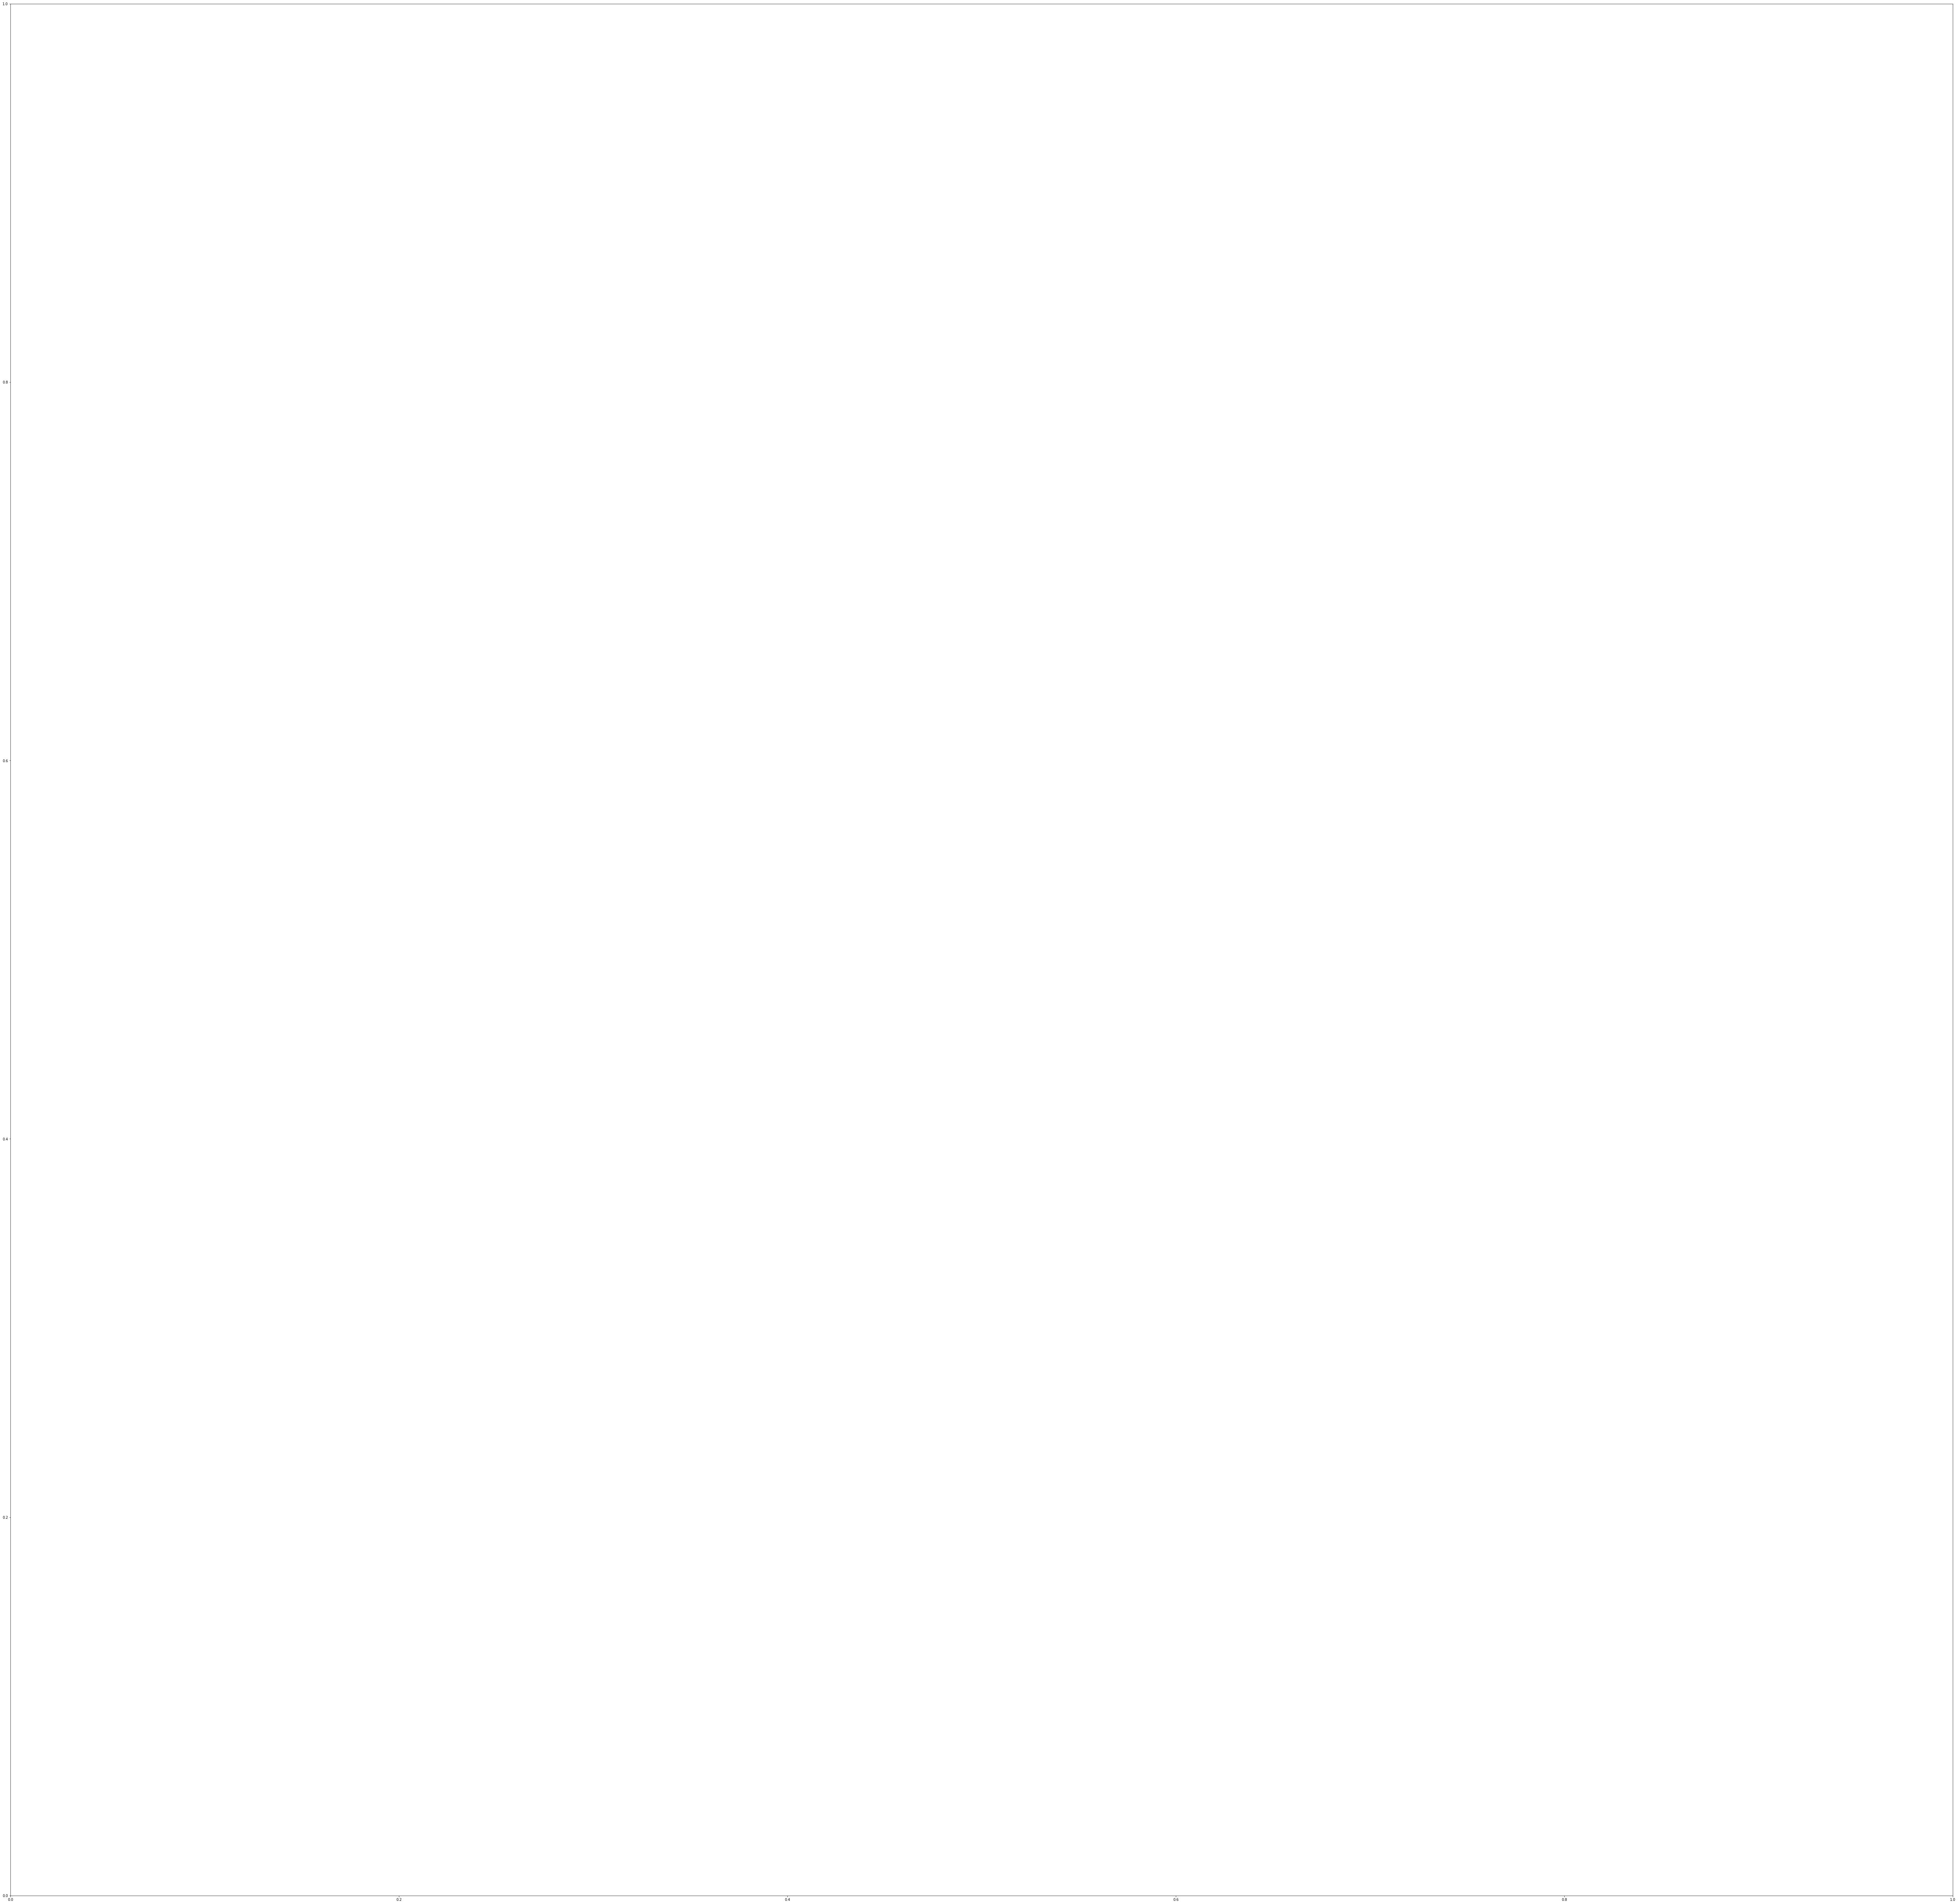

In [544]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
fig, ax = plt.subplots(figsize=(100, 100))
plot_tree(clf, ax = ax)
plt.show()

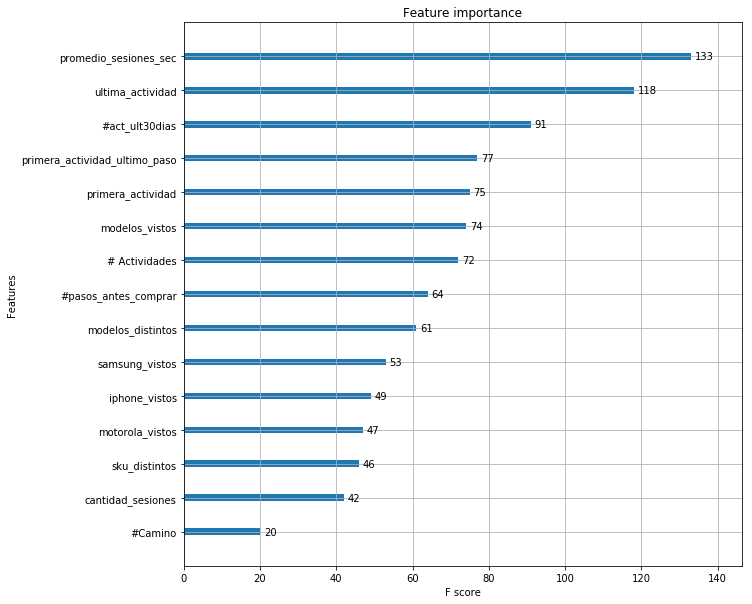

In [545]:
fig, ax = plt.subplots(figsize=(10,10))
plot_importance(clf, ax=ax)
plt.show()

In [533]:
y_test

,label
36023,1.0
4991,1.0
34813,1.0
8319,1.0
33286,0.0
30954,1.0
32422,0.0
39661,0.0
38325,1.0
17663,1.0


In [534]:
y_pred

array([1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
       1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
       0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1.,
       1., 0., 0., 1., 0.

In [535]:
y_test['pred'] = pd.Series(y_pred).values

C:\Users\RAUL\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [536]:
y_test

,label,pred
36023,1.0,1.0
4991,1.0,0.0
34813,1.0,1.0
8319,1.0,0.0
33286,0.0,1.0
30954,1.0,1.0
32422,0.0,0.0
39661,0.0,0.0
38325,1.0,0.0
17663,1.0,1.0


In [537]:
confusion_matrix(y_test['label'], y_test['pred'])

array([[199,  84],
       [115, 190]], dtype=int64)

In [538]:
print (f1_score(y_test['label'], y_test['pred']))

0.6563039723661487


In [539]:
print (recall_score(y_test['label'], y_test['pred']))

0.6229508196721312


In [540]:
print (roc_auc_score(y_test['label'], y_test['pred']))


0.6630655158431328


In [387]:
X_test

,#Camino,#pasos_antes_comprar,primera_actividad,modelos_vistos,modelos_distintos,sku_distintos,cantidad_sesiones,promedio_sesiones_sec,#act_ult30dias,primera_actividad_ultimo_paso,ultima_actividad,# Actividades
36023,0,287,126,228.0,35.0,113.0,15,312.0,81.0,126,1,287
4991,0,35,6,11.0,3.0,9.0,3,151.0,35.0,6,0,35
34813,0,10,98,6.0,4.0,5.0,1,265.0,0.0,98,98,10
8319,0,40,7,20.0,7.0,15.0,5,425.0,40.0,7,0,40
33286,0,24,54,7.0,1.0,4.0,3,149.0,12.0,54,12,24
30954,0,3,26,1.0,1.0,1.0,1,2.0,3.0,26,26,3
32422,0,4,1,1.0,1.0,1.0,1,13.0,4.0,1,1,4
39661,0,9,0,2.0,1.0,2.0,1,147.0,9.0,0,0,9
38325,0,22,22,5.0,1.0,2.0,3,562.0,22.0,22,3,22
17663,0,6,79,3.0,1.0,1.0,2,66.0,0.0,79,77,6


In [305]:
import stats

ModuleNotFoundError: No module named 'stats'

In [349]:
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn import cross_validation
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': stats.randint(150, 500),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3]
             }
clf = RandomizedSearchCV(clf_xgb, param_distributions = param_dist, n_iter = 25, scoring = 'roc_auc', error_score = 0, verbose = 3, n_jobs = -1)

numFolds = 10
folds = cross_validation.KFold(n = len(X), shuffle = True, n_folds = numFolds)

estimators = []
results = np.zeros(len(X))
score = 0.0
for train_index, test_index in folds:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
    clf.fit(X_train, y_train)

    estimators.append(clf.best_estimator_)
    results[test_index] = clf.predict(X_test)
    score += roc_auc_score(y_test, results[test_index])
score /= numFolds

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   12.0s finished
C:\Users\RAUL\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   14.8s finished
C:\Users\RAUL\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   14.8s finished
C:\Users\RAUL\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   15.2s finished
C:\Users\RAUL\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   14.8s finished
C:\Users\RAUL\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   14.4s finished
C:\Users\RAUL\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   18.9s finished
C:\Users\RAUL\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   13.4s finished
C:\Users\RAUL\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   13.1s finished
C:\Users\RAUL\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   12.4s finished
C:\Users\RAUL\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [350]:
estimators

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.6838567544401499, gamma=0,
        learning_rate=0.014244586512237912, max_delta_step=0, max_depth=4,
        min_child_weight=2, missing=None, n_estimators=258, n_jobs=1,
        nthread=None, objective='binary:logistic', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=True, subsample=0.49879960232255705),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.5406053440252765, gamma=0,
        learning_rate=0.026110743250192074, max_delta_step=0, max_depth=4,
        min_child_weight=3, missing=None, n_estimators=227, n_jobs=1,
        nthread=None, objective='binary:logistic', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=True, subsample=0.4437276661745052),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_byt

In [351]:
score

0.6844905793680905

In [352]:
results

array([1., 0., 1., ..., 1., 0., 1.])

In [327]:
X.reset_index(drop=True)

,#Camino,#pasos_antes_comprar,primera_actividad,modelos_vistos,modelos_distintos,sku_distintos,cantidad_sesiones,promedio_sesiones_sec,#act_ult30dias,primera_actividad_ultimo_paso,ultima_actividad,# Actividades
0,0,56,55,30.0,3.0,17.0,8,245.0,8.0,55,10,56
1,0,9,14,5.0,1.0,3.0,1,128.0,9.0,14,14,9
2,0,277,65,235.0,10.0,101.0,12,304.0,35.0,65,12,277
3,0,216,65,167.0,28.0,69.0,24,327.0,101.0,65,3,216
4,0,206,6,169.0,31.0,83.0,3,2771.0,206.0,6,5,206
5,0,53,70,30.0,8.0,15.0,6,254.0,12.0,70,24,53
6,2,81,9,27.0,5.0,17.0,14,373.0,94.0,9,0,94
7,1,7,24,3.0,2.0,3.0,13,396.0,180.0,16,9,180
8,0,712,68,609.0,20.0,151.0,56,372.0,299.0,68,8,712
9,0,17,1,8.0,2.0,4.0,1,329.0,17.0,1,1,17


In [388]:
test = paths2.drop_duplicates('person', keep='last')

In [389]:
test.head()

,person,#Camino,#pasos_antes_comprar,primera_actividad,modelos_vistos,modelos_distintos,sku_distintos,cantidad_sesiones,promedio_sesiones_sec,#act_ult30dias,primera_actividad_ultimo_paso,ultima_actividad,# Actividades,label,_merge
0,0008ed71,0,6,14,0.0,0.0,0.0,3,135.0,6.0,14,14,6,0.0,both
1,00091926,0,448,28,372.0,36.0,164.0,34,438.0,448.0,28,0,448,NaN,left_only
2,00091a7a,0,10,66,3.0,3.0,3.0,1,347.0,0.0,66,66,10,NaN,left_only
3,000ba417,0,205,14,153.0,26.0,81.0,5,2541.0,206.0,14,5,206,NaN,left_only
4,000c79fe,0,17,2,3.0,1.0,1.0,1,620.0,17.0,2,2,17,0.0,both


In [390]:
test.shape

(38829, 15)

In [391]:
test = test[test['_merge'] == 'left_only']

In [392]:
del test['label']
del test['_merge']


In [393]:
test.shape

(19415, 13)

In [394]:
test_X = test[list(X.columns.values)]

In [395]:
test_X

,#Camino,#pasos_antes_comprar,primera_actividad,modelos_vistos,modelos_distintos,sku_distintos,cantidad_sesiones,promedio_sesiones_sec,#act_ult30dias,primera_actividad_ultimo_paso,ultima_actividad,# Actividades
1,0,448,28,372.0,36.0,164.0,34,438.0,448.0,28,0,448
2,0,10,66,3.0,3.0,3.0,1,347.0,0.0,66,66,10
3,0,205,14,153.0,26.0,81.0,5,2541.0,206.0,14,5,206
5,0,411,15,339.0,37.0,105.0,13,1012.0,411.0,15,1,411
6,0,68,16,28.0,23.0,25.0,5,246.0,68.0,16,13,68
8,1,3,15,0.0,0.0,0.0,3,1122.0,68.0,15,9,68
9,0,4,1,1.0,1.0,1.0,1,43.0,4.0,1,1,4
10,0,4,2,1.0,1.0,1.0,1,2.0,4.0,2,2,4
13,1,3,6,0.0,0.0,0.0,2,404.0,4.0,6,3,4
17,0,16,11,6.0,2.0,2.0,1,875.0,16.0,11,11,16


In [396]:
test_X

,#Camino,#pasos_antes_comprar,primera_actividad,modelos_vistos,modelos_distintos,sku_distintos,cantidad_sesiones,promedio_sesiones_sec,#act_ult30dias,primera_actividad_ultimo_paso,ultima_actividad,# Actividades
1,0,448,28,372.0,36.0,164.0,34,438.0,448.0,28,0,448
2,0,10,66,3.0,3.0,3.0,1,347.0,0.0,66,66,10
3,0,205,14,153.0,26.0,81.0,5,2541.0,206.0,14,5,206
5,0,411,15,339.0,37.0,105.0,13,1012.0,411.0,15,1,411
6,0,68,16,28.0,23.0,25.0,5,246.0,68.0,16,13,68
8,1,3,15,0.0,0.0,0.0,3,1122.0,68.0,15,9,68
9,0,4,1,1.0,1.0,1.0,1,43.0,4.0,1,1,4
10,0,4,2,1.0,1.0,1.0,1,2.0,4.0,2,2,4
13,1,3,6,0.0,0.0,0.0,2,404.0,4.0,6,3,4
17,0,16,11,6.0,2.0,2.0,1,875.0,16.0,11,11,16


In [397]:
test_Y = clf.predict(test_X)

C:\Users\RAUL\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [398]:
test_Y

array([1., 1., 1., ..., 0., 1., 0.])

In [399]:
test['label'] = pd.Series(test_Y).values

In [400]:
test

,person,#Camino,#pasos_antes_comprar,primera_actividad,modelos_vistos,modelos_distintos,sku_distintos,cantidad_sesiones,promedio_sesiones_sec,#act_ult30dias,primera_actividad_ultimo_paso,ultima_actividad,# Actividades,label
1,00091926,0,448,28,372.0,36.0,164.0,34,438.0,448.0,28,0,448,1.0
2,00091a7a,0,10,66,3.0,3.0,3.0,1,347.0,0.0,66,66,10,1.0
3,000ba417,0,205,14,153.0,26.0,81.0,5,2541.0,206.0,14,5,206,1.0
5,000e4d9e,0,411,15,339.0,37.0,105.0,13,1012.0,411.0,15,1,411,1.0
6,000e619d,0,68,16,28.0,23.0,25.0,5,246.0,68.0,16,13,68,0.0
8,001001be,1,3,15,0.0,0.0,0.0,3,1122.0,68.0,15,9,68,0.0
9,0010e89a,0,4,1,1.0,1.0,1.0,1,43.0,4.0,1,1,4,0.0
10,0016c4b5,0,4,2,1.0,1.0,1.0,1,2.0,4.0,2,2,4,0.0
13,001804a2,1,3,6,0.0,0.0,0.0,2,404.0,4.0,6,3,4,0.0
17,001a2273,0,16,11,6.0,2.0,2.0,1,875.0,16.0,11,11,16,0.0


In [401]:
date = str(datetime.datetime.now().strftime('%d_%m_%Y_%H_%M_%S'))
training_file_name = 'C:\\Users\\RAUL\\Documents\\OrgDatos2\\TP2\\Training Sets\\training_' + date + '.csv'
file_name = 'C:\\Users\\RAUL\\Documents\\OrgDatos2\\TP2\\Submits\\' + date + '.csv'

In [402]:
training.to_csv(training_file_name)
test[['person','label']].to_csv(file_name, index = False)

In [403]:
X.shape

(1372, 12)